# Machine Learning & Energy WS 20/21
# Exercise 6 - Part I: Deep Neural Networks in TensorFlow & Keras

In this exercise you will learn how to use TensorFlow for creating machine learning models and especially neural networks.
Throughout the exercise, we will use the Keras interface which allows much simpler and faster creation of models than native TensorFlow.
You can finde the Keras documentation here: https://keras.io/api/.

In this notebook you will learn the basic workflow for creating and training models.
In the second notebook you will create a convolutional neural network that learns to classify cloud types from images. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_circles
import tensorflow as tf
from tensorflow import keras
from plot_decision_boundary import plot_decision_boundary
import models
tf.keras.backend.clear_session()
tf.random.set_seed(123)

## 1. Linear regression
We will start by demonstrating how to build a linear regression model using Keras.
#### a) Run the cell below to create a small toy data set.

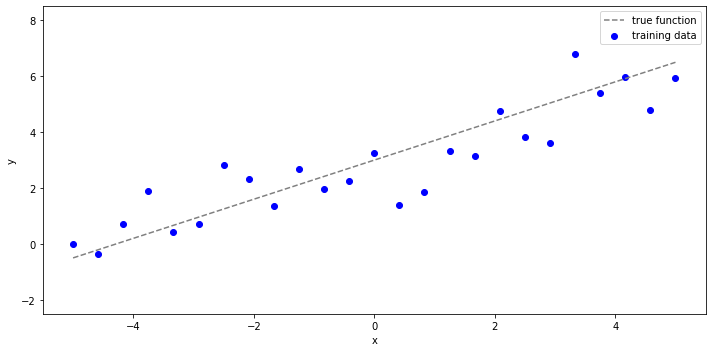

In [12]:
# set some parameters
N_TRAIN_linreg = 25    # number of training examples
NOISE_STD_linreg = 1.0 # standard deviation for Gaussian noise

# toy function
def toy_fcn_linreg(x, sigma=NOISE_STD_linreg, seed=42):
    return 3 + 0.7*x + np.random.RandomState(seed).normal(0, sigma, x.shape)

# draw a lot of samples from the true function
X_true_linreg = np.expand_dims(np.linspace(-5.0,5.0,500),1)
y_true_linreg = toy_fcn_linreg(X_true_linreg, sigma=0)

# but we only obtain some noisy observations from the function (the training data):
X_train_linreg = np.expand_dims(np.linspace(-5.0, 5.0, N_TRAIN_linreg),1)
y_train_linreg = toy_fcn_linreg(X_train_linreg)

# plot true function and training data
plt.figure(figsize=(10,5))
plt.plot(X_true_linreg, y_true_linreg, label="true function", linestyle="--", color="gray")
plt.scatter(X_train_linreg, y_train_linreg, label="training data", color="blue")
plt.ylim(np.min(y_true_linreg)-2, np.max(y_true_linreg)+2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

#### b) Open the module ``models.py`` and take a look at the implementation of the linear regression model in the function ``build_linreg_model``.

This is what happens in the code:

- The first layer needs to be an input layer which specifies the shape of the model input: ``x = layers.Input(shape=(dim_in,))`` does exactly that. We named the output of the layer ``x``.

- We can now feed the output of the input layer to the next layer. This is a dense layer (i.e. a fully connected layer) with a single neuron: ``y = layers.Dense(units=1)(x)``. We named the output of this layer ``y``.

- By running ``mdl = keras.Model(inputs=x, outputs=y)`` we instantiate a model named ``mdl`` and declare that the inputs are ``x`` and the outputs are ``y``. All layers that are connected directly or indirectly to ``x`` and ``y`` will be part of the model graph.

- Finally we have to compile the model and declare the loss and the optimizer using ``mdl.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss="mse")``. We use gradient descent optimization and set the loss to "mse" (i.e. the mean squared error) since we are doing linear regression.

#### c) Run the cell below to build the linear regression model. The code prints the model summary and plots the model structure.

Model: "linreg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


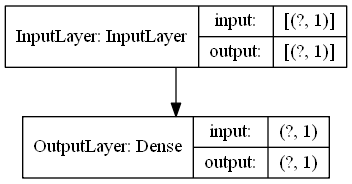

In [14]:
# build linear regression model
model_linreg = models.build_linreg_model(dim_in=X_train_linreg.shape[1])

# model summary
model_linreg.summary()
img=keras.utils.plot_model(model_linreg, "linreg_model.png", show_shapes=True, dpi=96, show_layer_names=True)
img

#### d) Like Scikit learn models, Keras models have a ``fit()`` and a ``predict()`` method. Run the two cells below to train the model running batch gradient descent for 100 epochs and to plot the learned function.
Note that the ``fit()`` method returns an object that contains a dictionary of training metrics that can be used to check the convergence of the optimization.

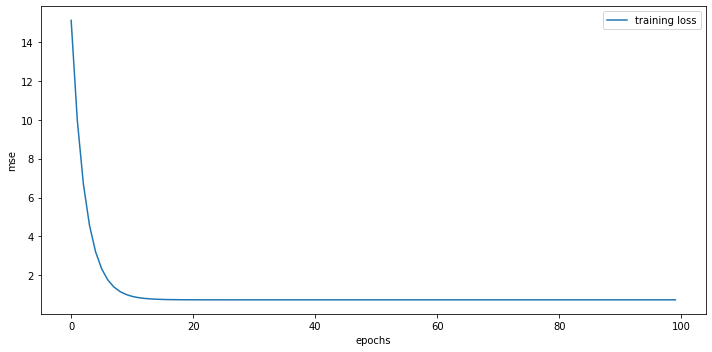

In [16]:
# train linear regression model
loss_linreg = model_linreg.fit(x=X_train_linreg, y=y_train_linreg, batch_size=X_train_linreg.shape[0], epochs=100, verbose=0)

# plot losses
plt.figure(figsize=(10,5))
plt.plot(loss_linreg.history["loss"], label="training loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("mse")
plt.tight_layout()

That looks good, the optimzer converged after 15 epochs. Let's look at the predictions and double check with linear regression from sklearn.

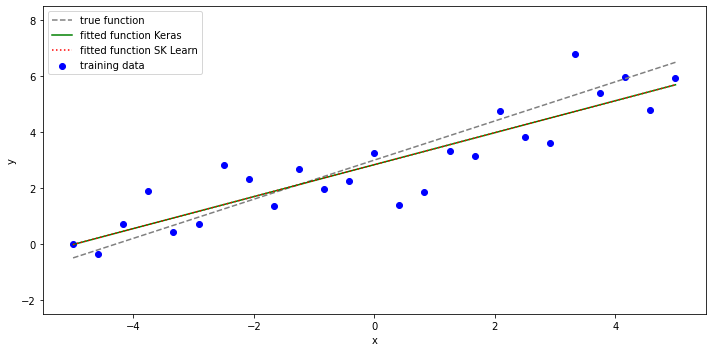

In [17]:
# predict from trained Keras linear regression model
y_pred_linreg = model_linreg.predict(X_true_linreg)

# check with linear regression from scikit learn
mdl_skl = LinearRegression().fit(X_train_linreg,y_train_linreg)
y_pred_linreg_skl = mdl_skl.predict(X_true_linreg)

# plot predictions
plt.figure(figsize=(10,5))
plt.plot(X_true_linreg, y_true_linreg, label="true function", linestyle="--", color="gray")
plt.scatter(X_train_linreg, y_train_linreg, label="training data", color="blue")
plt.plot(X_true_linreg, y_pred_linreg, color="green", label="fitted function Keras")
plt.plot(X_true_linreg, y_pred_linreg_skl, color="red", linestyle=":", label="fitted function SK Learn")
plt.ylim(np.min(y_true_linreg)-2, np.max(y_true_linreg)+2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

## 2. Logistic Regression

Now you will use Keras to build a logistic regression model.
#### a) Run the cell below the create a simple binary classification problem.

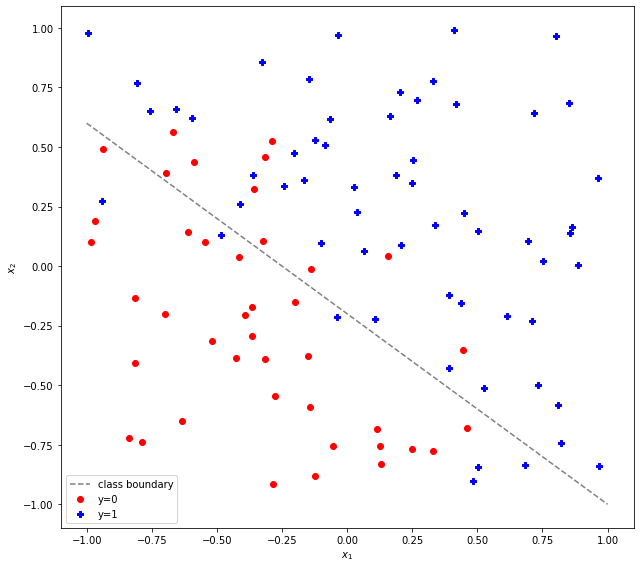

In [18]:
N_TRAIN_logreg = 100  # number of training examples
NOISE_STD_logreg = 0.3  # standard deviation for Gaussian noise

def toy_fcn_logreg(x, sigma=NOISE_STD_logreg, seed=123):
    return 1.0*(x[:,1] > -0.8*x[:,0]-0.2 + np.random.RandomState(seed).normal(0, sigma, x.shape[0]))

# Generate data
X_logreg = np.random.RandomState(123).uniform(low=-1.0,high=1.0,size=[N_TRAIN_logreg,2])
y_logreg = toy_fcn_logreg(X_logreg, NOISE_STD_logreg)

# Plot data
plt.figure(figsize=(9,8))
plt.scatter(*X_logreg[y_logreg==0].T, color="red", label="y=0")
plt.scatter(*X_logreg[y_logreg==1].T, color="blue", label="y=1", marker="P")
plt.plot(np.linspace(-1.0,1.0,500), -0.8*np.linspace(-1.0,1.0,500)-0.2, color="grey", linestyle="--", label="class boundary")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.tight_layout()

#### b) Complete the function ``build_logreg()`` in the module ``models``.
#### c) Run the cell below to build the model and print the model summary.

Model: "logreg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 3         
_________________________________________________________________
layers_sigmoid_function (Act (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


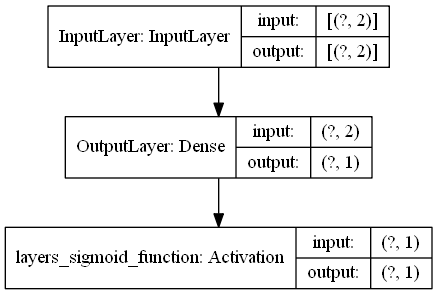

In [19]:
model_logreg = models.build_logreg_model(dim_in=X_logreg.shape[1])
model_logreg.summary()
img=keras.utils.plot_model(model_logreg, "logreg_model.png", show_shapes=True, dpi=96, show_layer_names=True)
img


Expected output:
<br>
<img src="images/logreg_model.png">

#### d) Run the cell below to train the model and to plot the training loss and the the learned decision boundary.

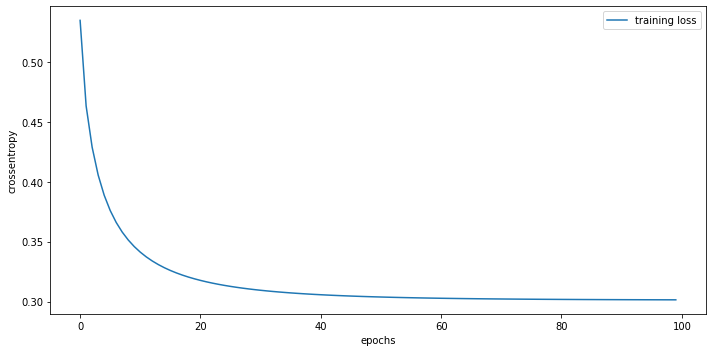

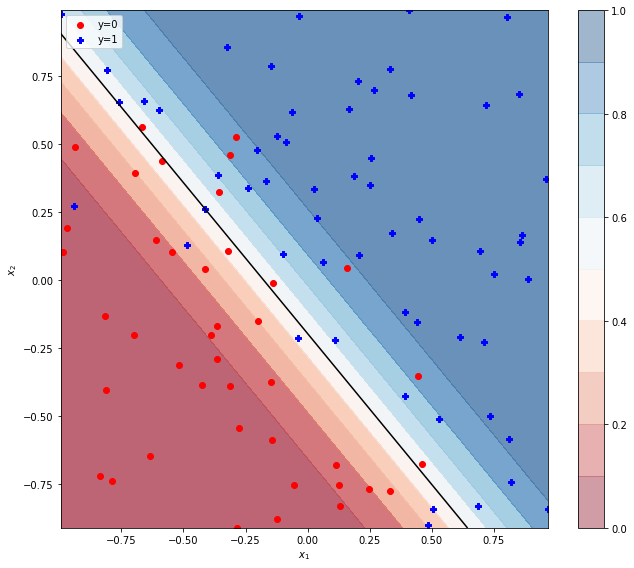

In [20]:
# fit logistic regression model
loss_logreg = model_logreg.fit(X_logreg,y_logreg, epochs=100, verbose=0, batch_size=X_logreg.shape[0])

# plot losses
plt.figure(figsize=(10,5))
plt.plot(loss_logreg.history["loss"], label="training loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.tight_layout()

# plot learned function
plot_decision_boundary(model_logreg,X_logreg,y_logreg)

Expected output:
<br>
<img src="images/loss_logreg.jpeg">
<br>
<img src="images/boundary_logreg.jpeg">

## 3. Non-linearly seperable data
So far we have worked with linear data sets only. Let's now look at a non-linear binary classification task and solve it using a neural network.
#### a) Run the cell below to create the data set.

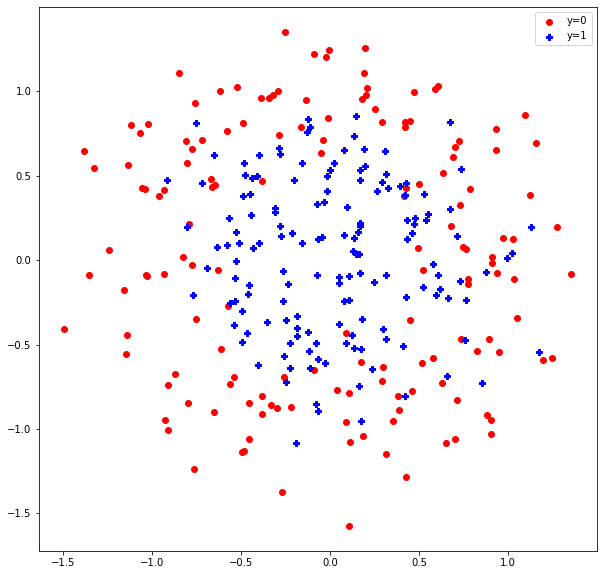

In [21]:
# make data set
data = make_circles(noise=0.25, factor=0.5, random_state=42, n_samples=300)
X,y = data[0],data[1]

# split in training and validation set
X_train,y_train = X[0:200], y[0:200]
X_val,y_val = X[200:], y[200:]

# plot data set
fig = plt.figure(figsize=(10,10))
plt.scatter(*X[y==0].T, color="red", label="y=0")
plt.scatter(*X[y==1].T, color="blue", label="y=1", marker="P")
_ = plt.legend()

We will now build a NN with three hidden layers with 50 neurons in each layer. All hidden layers use the ReLU activation. Again the input layer will have dimension 2 and the output layer will have a single unit as we are still doing binary classification.
#### b) Write down the formula for the forward pass. How many parameters does this model have? 75650

#### c) Complete the function ``build_NN_model()`` in the module ``models.py`` that defines the neural network model described above.
#### d) Run the cell below to build the model and print the model summary.

Model: "logreg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
y (Dense)                    (None, 50)                150       
_________________________________________________________________
z (Dense)                    (None, 50)                2550      
_________________________________________________________________
a (Dense)                    (None, 50)                2550      
_________________________________________________________________
b (Dense)                    (None, 1)                 51        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


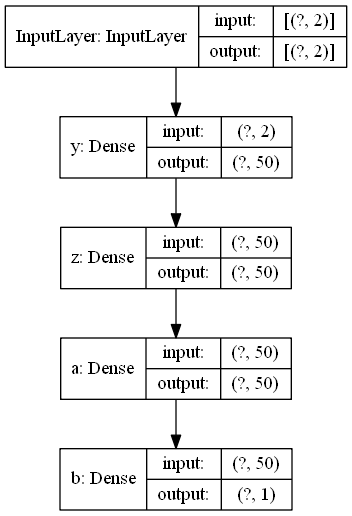

In [22]:
# define some hyper parameters
N_NEURONS = 50
BATCH_SIZE = 32
OPTIMIZER = "adam"
N_EPOCHS = 250

# build model
NN = models.build_NN_model(dim_in=X.shape[1], n_neurons=N_NEURONS, optimizer=OPTIMIZER)

# summary
NN.summary()
img=keras.utils.plot_model(NN, "NN_model.png", show_shapes=True, dpi=96, show_layer_names=True)
img

Expected output:
<br>
<img src="images/NN_model.png">

#### e) Run the cell below to train your NN for 250 epochs and a batch size of 32 and to plot the learned decision boundary. What do you observe?

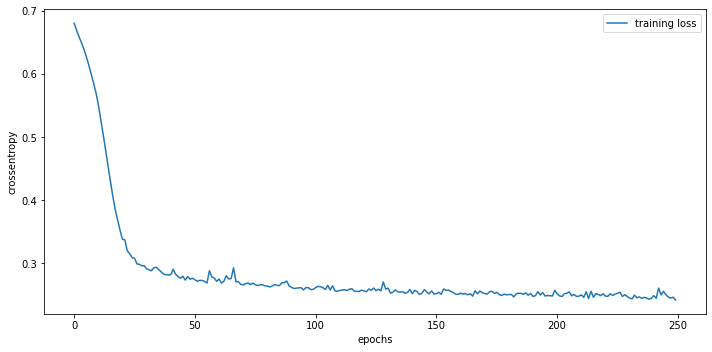

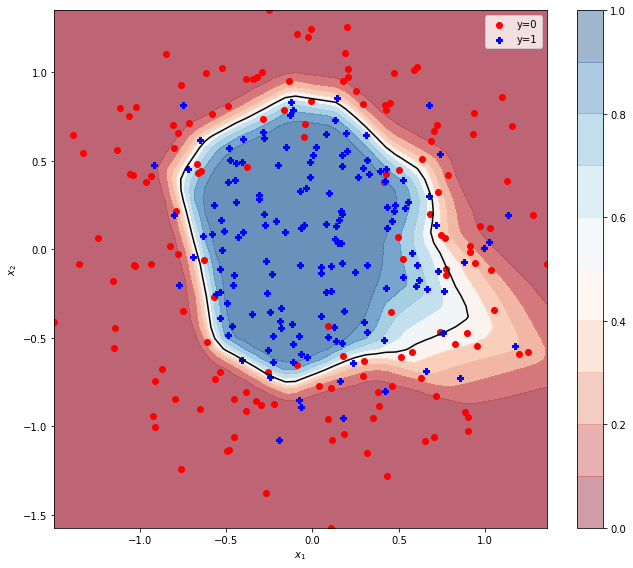

In [23]:
# train models
loss_NN = NN.fit(X_train,y_train,epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=0)

# plot training losses
plt.figure(figsize=(10,5))
plt.plot(loss_NN.history["loss"], label="training loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.tight_layout()

# plot learned decision function
plot_decision_boundary(NN, X, y)

Expected output:
<br>
<img src="images/loss_NN1.jpeg">
<br>
<img src="images/boundary_NN1.jpeg">

## 4. Early stopping
A simple and effective way to counter overfitting is early stopping.
#### a) Complete the function ``early_stopping()`` in the module ``early_stopping.py``. 
The function implements the early stopping algorithm. The function inputs are a compiled model, the training data, the validation data, the number of maximum iterations, the batch size, and a patience parameter. The function then fits the model and sets the model's weights to the weights from the epoch with the lowest validation loss. The ``patience`` parameter controls how long to wait before to interrupt the training, i.e. ``patience=10`` breaks the training loop after the validation loss did not reach a new minimum for 10 consecutive epochs. The function returns the training and validation losses from all epochs.

You might want to use these methods:
- ``model.get_weights()`` returns a list of model weights.
-  ``model.set_weights()`` sets the model weights.
- ``model.test_on_batch(X,y)`` returns the scalar loss of the model for the data in X,y.


#### b) Run the cell below to use early stopping to train your neural network. What do you observe?

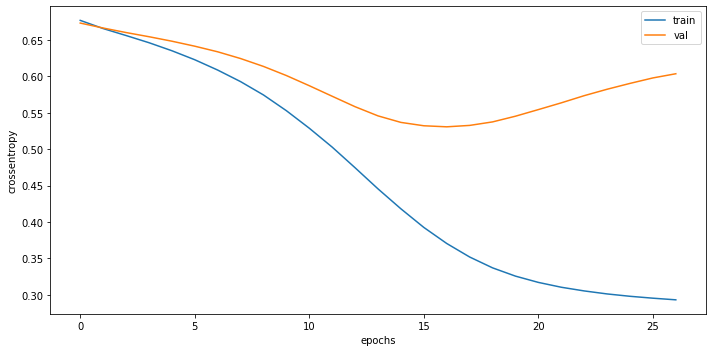

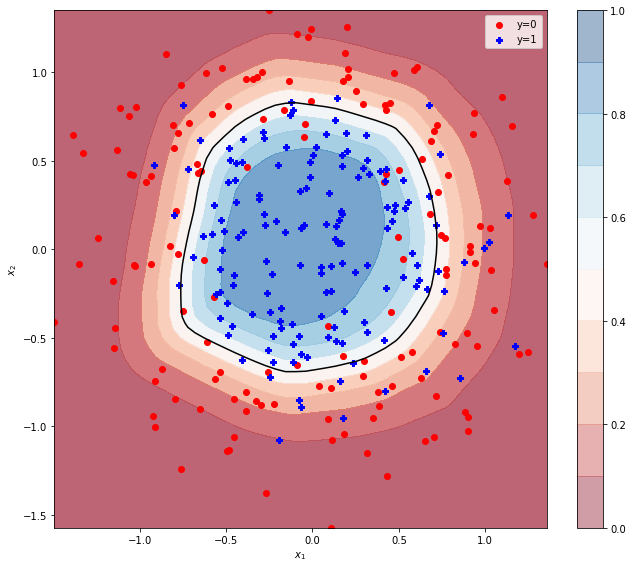

In [25]:
# rebuild NN model
NN = models.build_NN_model(dim_in=X.shape[1], n_neurons=N_NEURONS, optimizer=OPTIMIZER)

# train with early stopping
from early_stopping import early_stopping
train_loss, val_loss = early_stopping(NN, X_train, y_train, X_val, y_val, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, patience=10)

# plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.tight_layout()

# plot learned decision function
plot_decision_boundary(NN, X, y)

Expected output:
<br>
<img src="images/loss_NN2.jpeg">
<br>
<img src="images/boundary_NN2.jpeg">

Of course Keras has its own implementation for early stopping. You can use early stopping via so called "callbacks" (see https://keras.io/api/callbacks/).
#### c) Run the cell below to use the Keras early stopping callback and plot the results. What do you observe?

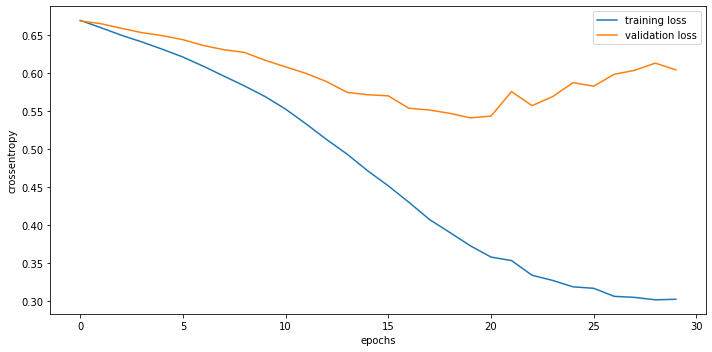

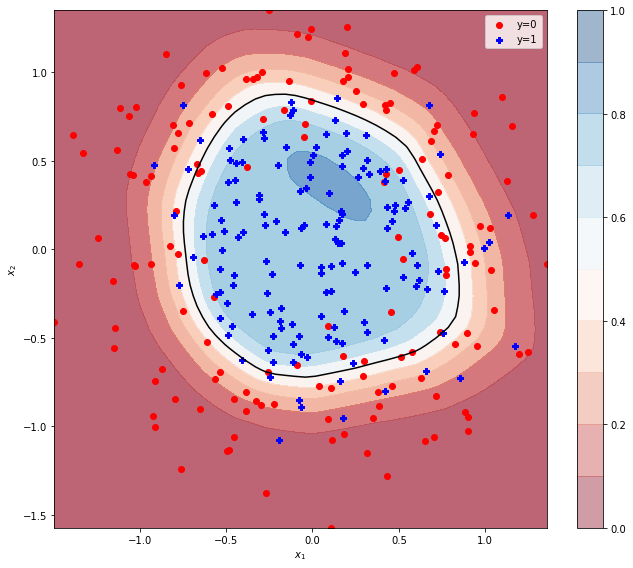

In [26]:
# rebuild NN model
NN = models.build_NN_model(dim_in=X.shape[1], n_neurons=N_NEURONS, optimizer=OPTIMIZER)

# define early stopping callback and train model
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=0, restore_best_weights=True)
loss_NN = NN.fit(X_train,y_train,epochs=N_EPOCHS, verbose=0, validation_data=(X_val,y_val), batch_size=BATCH_SIZE, callbacks=early_stopping)

# plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(loss_NN.history["loss"], label="training loss")
plt.plot(loss_NN.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.tight_layout()

# plot learned decision function
plot_decision_boundary(NN, X, y)

Expected output:
<br>
<img src="images/loss_NN3.jpeg">
<br>
<img src="images/boundary_NN3.jpeg">

#### d) Can you think of possible disadvantages of using early stopping? What other options could you try to counter overftting?

Now open the notebook ``Exercise_06_CloudClassification``.